## Наглядный пример регуляризации логистической регрессии

Посмотрим, как регуляризация влияет на качество классификации на наборе данных по тестированию микрочипов из курса Andrew Ng по машинному обучению.
Будем использовать логистическую регрессию с полиномиальными признаками и варьировать параметр регуляризации C.
Сначала посмотрим, как регуляризация влияет на разделяющую границу классификатора, интуитивно распознаем переобучение и недообучение.
Потом численно установим близкий к оптимальному параметр регуляризации с помощью кросс-валидации (cross-validation) и перебора по сетке (GridSearch).

In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

Загружаем данные с помощью метода read_csv библиотеки pandas. В этом наборе данных для 118 микрочипов (объекты) указаны результаты двух тестов по контролю качества (два числовых признака) и сказано, пустили ли микрочип в производство. Признаки уже центрированы, то есть из всех значений вычтены средние по столбцам. Таким образом, "среднему" микрочипу соответствуют нулевые значения результатов тестов.

In [3]:
data = pd.read_csv('resources/microchip_tests.txt',
header=None, names = ('test1','test2','released'))
# информация о наборе данных
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   test1     118 non-null    float64
 1   test2     118 non-null    float64
 2   released  118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


Посмотрим на первые и последние 5 строк.

In [4]:
print(data.head())

print(data.tail())

      test1    test2  released
0  0.051267  0.69956         1
1 -0.092742  0.68494         1
2 -0.213710  0.69225         1
3 -0.375000  0.50219         1
4 -0.513250  0.46564         1
        test1     test2  released
113 -0.720620  0.538740         0
114 -0.593890  0.494880         0
115 -0.484450  0.999270         0
116 -0.006336  0.999270         0
117  0.632650 -0.030612         0


Сохраним обучающую выборку и метки целевого класса в отдельных массивах NumPy. Отобразим данные. Красный цвет соответствует бракованным чипам, зеленый – нормальным.

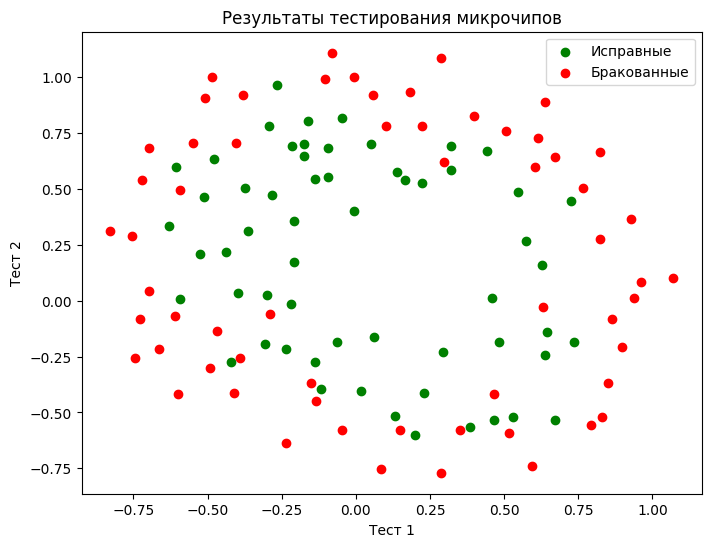

In [ ]:
# Разделяем признаки и целевую переменную
X = data[['test1', 'test2']].values
y = data['released'].values

# Разделяем данные по классам для визуализации
pos = y == 1  # исправные чипы
neg = y == 0  # бракованные

# Визуализация
plt.figure(figsize=(8,6))
plt.scatter(X[pos, 0], X[pos, 1], c='g', label='Исправные')
plt.scatter(X[neg, 0], X[neg, 1], c='r', label='Бракованные')
plt.xlabel('Тест 1')
plt.ylabel('Тест 2')
plt.title('Результаты тестирования микрочипов')
plt.legend()
plt.grid(True)
plt.show()

Определяем функцию для отображения разделяющей кривой классификатора

In [15]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
  x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
  y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
  np.arange(y_min, y_max, grid_step))

  # каждой точке в сетке [x_min, m_max]x[y_min, y_max]
  # ставим в соответствие свой цвет
  Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
  Z = Z.reshape(xx.shape)
  plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

Полиномиальными признаками до степени $d$ для двух переменных $x_1$ и $x_2$ мы называем следующие:

$\large \{x_1^d, x_1^{d-1}x_2, \ldots x_2^d\} = \{x_1^ix_2^j\}_{i+j \leq d, i,j \in \mathbb{N}}$

Например, для $d=3$ это будут следующие признаки:

$\large 1, x_1, x_2, x_1^2, x_1x_2, x_2^2, x_1^3, x_1^2x_2, x_1x_2^2, x_2^3$

Нарисовав треугольник Пифагора, Вы сообразите, сколько таких признаков будет для $d=4,5...$ и вообще для любого $d$.
Попросту говоря, таких признаков экспоненциально много, и строить, скажем, для 100 признаков полиномиальные степени 10 может оказаться затратно (а более того, и не нужно).


Создадим объект sklearn, который добавит в матрицу $X$ полиномиальные признаки вплоть до степени 7 и обучим логистическую регрессию с параметром регуляризации $C = 10^{-2}$. Изобразим разделяющую границу.
Также проверим долю правильных ответов классификатора на обучающей выборке. Видим, что регуляризация оказалась слишком сильной, и модель "недообучилась". Доля правильных ответов классификатора на обучающей выборке оказалась равной 0.627.

In [17]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

Доля правильных ответов классификатора на обучающей выборке: 0.627


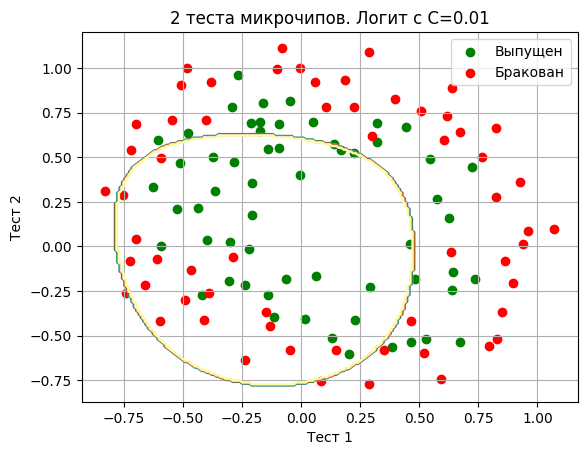

In [ ]:
C = 1e-2
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=0.01')
plt.grid(True)
plt.legend()

print("Доля правильных ответов классификатора на обучающей выборке:", 
round(logit.score(X_poly, y), 3))

Увеличим $C$ до 1. Тем самым мы ослабляем регуляризацию, теперь в решении значения весов логистической регрессии могут оказаться больше (по модулю), чем в прошлом случае. Теперь доля правильных ответов классификатора на обучающей выборке – 0.831.

Доля правильных ответов классификатора на обучающей выборке: 0.831


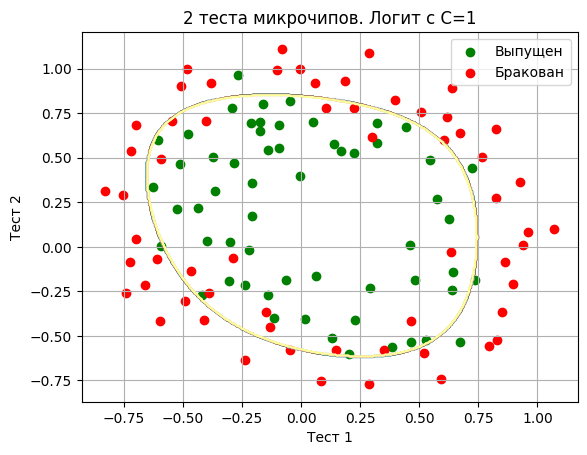

In [23]:
C = 1
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=1')
plt.grid(True)
plt.legend()

print("Доля правильных ответов классификатора на обучающей выборке:", 
round(logit.score(X_poly, y), 3))

Еще увеличим $C$ – до 10 тысяч. Теперь регуляризации явно недостаточно, и мы наблюдаем переобучение. Можно заметить, что в прошлом случае (при $C$=1 и "гладкой" границе) доля правильных ответов модели на обучающей выборке не намного ниже, чем в 3 случае, зато на новой выборке, можно себе представить, 2 модель сработает намного лучше.
Доля правильных ответов классификатора на обучающей выборке – 0.873.

Доля правильных ответов классификатора на обучающей выборке: 0.873


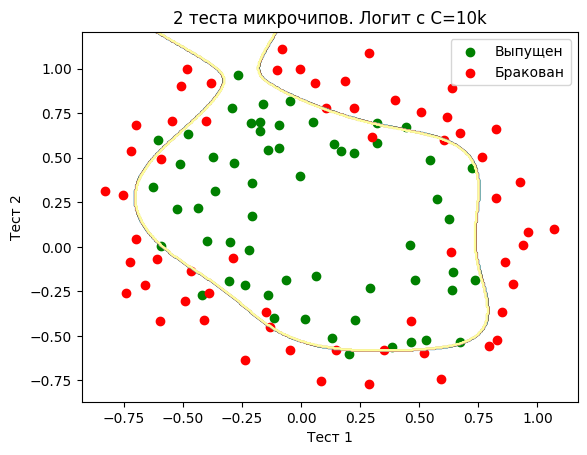

In [24]:
C = 1e4
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=10k')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", 
round(logit.score(X_poly, y), 3))

Чтоб обсудить результаты, перепишем формулу для функционала, который оптимизируется в логистической регрессии, в таком виде:

$$\large J(X,y,w) = \mathcal{L} + \frac{1}{C}||w||^2$$

где

- $\mathcal{L}$ – логистическая функция потерь, просуммированная по всей выборке
- $C$ – обратный коэффициент регуляризации (тот самый $C$ в sklearn-реализации LogisticRegression)


Промежуточные выводы:

- чем больше параметр $C$, тем более сложные зависимости в данных может восстанавливать модель (интуитивно $C$ соответствует "сложности" модели (model capacity))
- если регуляризация слишком сильная (малые значения $C$), то решением задачи минимизации логистической функции потерь может оказаться то, когда многие веса занулились или стали слишком малыми. Еще говорят, что модель недостаточно "штрафуется" за ошибки (то есть в функционале $J$ "перевешивает" сумма квадратов весов, а ошибка $\mathcal{L}$ может быть относительно большой). В таком случае модель окажется недообученной (1 случай)
- наоборот, если регуляризация слишком слабая (большие значения $C$), то решением задачи оптимизации может стать вектор $w$ с большими по модулю компонентами. В таком случае больший вклад в оптимизируемый функционал $J$ имеет $\mathcal{L}$ и, вольно выражаясь, модель слишком "боится" ошибиться на объектах обучающей выборки, поэтому окажется переобученной (3 случай)
- то, какое значение $C$ выбрать, сама логистическая регрессия "не поймет" (или еще говорят "не выучит"), то есть это не может быть определено решением оптимизационной задачи, которой является логистическая регрессия (в отличие от весов $w$). Так же точно, дерево решений не может "само понять", какое ограничение на глубину выбрать (за один процесс обучения). Поэтому $C$ – это гиперпараметр модели, который настраивается на кросс-валидации, как и max_depth для дерева.

### Настройка параметра регуляризации

Теперь найдем оптимальное (в данном примере) значение параметра регуляризации $C$. Сделать это можно с помощью LogisticRegressionCV – перебора параметров по сетке с последующей кросс-валидацией. Этот класс создан специально для логистической регрессии (для нее известны эффективные алгоритмы перебора параметров), для произвольной модели мы бы использовали GridSearchCV, RandomizedSearchCV или, например, специальные алгоритмы оптимизации гиперпараметров, реализованные в hyperopt.

In [25]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_poly, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.5s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished


,Cs,array([1.0000...00000000e+03])
,fit_intercept,True
,cv,StratifiedKFo... shuffle=True)
,dual,False
,penalty,'l2'
,scoring,None
,solver,'lbfgs'
,tol,0.0001
,max_iter,100
,class_weight,None
,n_jobs,-1


Посмотрим, как качество модели (доля правильных ответов на обучающей и валидационной выборках) меняется при изменении гиперпараметра $C$.

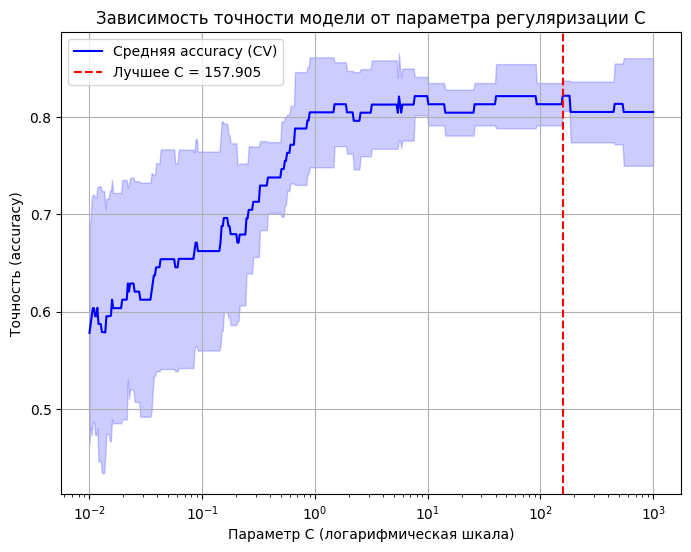

In [32]:
mean_scores = logit_searcher.scores_[1].mean(axis=0)  # средние accuracy по фолдам для класса "1"
std_scores = logit_searcher.scores_[1].std(axis=0)    # стандартное отклонение

# Отображаем график
plt.figure(figsize=(8,6))
plt.semilogx(c_values, mean_scores, label='Средняя accuracy (CV)', color='b')
plt.fill_between(c_values, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2, color='b')

# Линия для лучшего значения C
best_C = logit_searcher.C_[0]
plt.axvline(best_C, color='r', linestyle='--', label=f'Лучшее C = {best_C:.3f}')

plt.xlabel('Параметр C (логарифмическая шкала)')
plt.ylabel('Точность (accuracy)')
plt.title('Зависимость точности модели от параметра регуляризации C')
plt.legend()
plt.grid(True)
plt.show()

Выделим участок с "лучшими" значениями C.

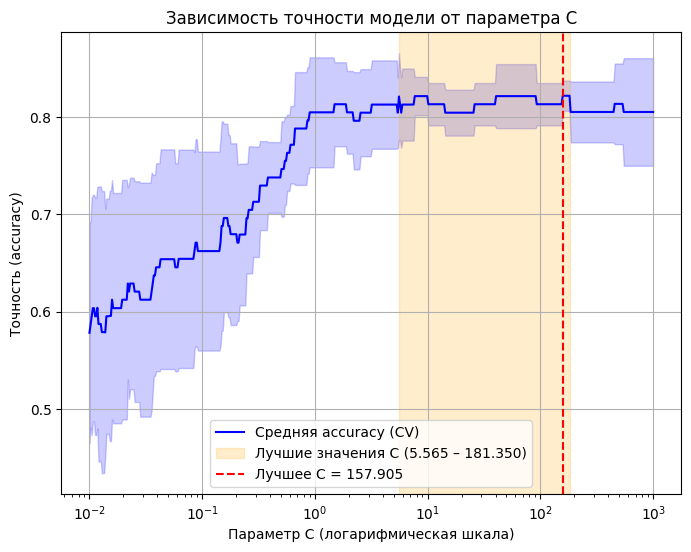

In [30]:
# Средние значения accuracy по фолдам
mean_scores = logit_searcher.scores_[1].mean(axis=0)
std_scores = logit_searcher.scores_[1].std(axis=0)

best_score = mean_scores.max()
best_C = logit_searcher.C_[0]

# Определяем диапазон "почти лучших" C (например, >= 99% от максимума)
threshold = 0.99 * best_score
mask_best = mean_scores >= threshold

# Получаем границы участка с лучшими значениями
C_best_min = c_values[mask_best].min()
C_best_max = c_values[mask_best].max()

# Визуализация
plt.figure(figsize=(8,6))
plt.semilogx(c_values, mean_scores, label='Средняя accuracy (CV)', color='b')
plt.fill_between(c_values, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2, color='b')

# Заливка участка с лучшими C
plt.axvspan(C_best_min, C_best_max, color='orange', alpha=0.2,
            label=f'Лучшие значения C ({C_best_min:.3f} – {C_best_max:.3f})')

# Линия лучшего C
plt.axvline(best_C, color='r', linestyle='--', label=f'Лучшее C = {best_C:.3f}')

plt.xlabel('Параметр C (логарифмическая шкала)')
plt.ylabel('Точность (accuracy)')
plt.title('Зависимость точности модели от параметра C')
plt.legend()
plt.grid(True)
plt.show()

Как мы помним, такие кривые называются валидационными, раньше мы их строили вручную, но в sklearn для них их построения есть специальные методы, которые мы тоже сейчас будем использовать.

### Анализ отзывов IMDB к фильмам

Будем решать задачу бинарной классификации отзывов IMDB к фильмам. Имеется обучающая выборка с размеченными отзывами, по 12500 отзывов известно, что они хорошие, еще про 12500 – что они плохие. Здесь уже не так просто сразу приступить к машинному обучению, потому что готовой матрицы $X$ нет – ее надо приготовить. Будем использовать самый простой подход – мешок слов ("Bag of words"). При таком подходе признаками отзыва будут индикаторы наличия в нем каждого слова из всего корпуса, где корпус – это множество всех отзывов. Идея иллюстрируется картинкой

In [33]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [34]:
reviews_train = load_files("aclImdb/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [35]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 75000
[12500 12500 50000]


In [36]:
reviews_test = load_files("aclImdb/test")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


#### Простой подсчет слов

Составим словарь всех слов с помощью CountVectorizer. Всего в выборке 74849 уникальных слов. Если посмотреть на примеры полученных "слов" (лучше их называть токенами), то можно увидеть, что многие важные этапы обработки текста мы тут пропустили (автоматическая обработка текстов – это могло бы быть темой отдельной серии статей).

In [37]:
cv = CountVectorizer()
cv.fit(text_train)

print(len(cv.vocabulary_)) #74849

124255


In [39]:
print(cv.get_feature_names_out()[:50])
print(cv.get_feature_names_out()[50000:50050])

['00' '000' '0000' '0000000000000000000000000000000001' '0000000000001'
 '000000001' '000000003' '00000001' '000001745' '00001' '0001' '00015'
 '0002' '0007' '00083' '000ft' '000s' '000th' '001' '002' '003' '003830'
 '004' '005' '006' '007' '0079' '008' '0080' '0083' '009' '0091042'
 '0093638' '00am' '00o' '00pm' '00s' '01' '015' '019' '01p' '01pm' '02'
 '020410' '022' '0267' '029' '03' '0312' '039']
['heathen' 'heathens' 'heather' 'heatherbennett' 'heatherly' 'heathers'
 'heatherton' 'heathkit' 'heathrow' 'heating' 'heatman' 'heatmiser'
 'heaton' 'heats' 'heatseeker' 'heatwave' 'heave' 'heaved' 'heaven'
 'heavenlier' 'heavenliness' 'heavenly' 'heavens' 'heavenward' 'heaves'
 'heavier' 'heavies' 'heaviest' 'heavily' 'heaviness' 'heaving' 'heavy'
 'heavyarms' 'heavyhanded' 'heavys' 'heavyset' 'heavyweight'
 'heavyweights' 'heber' 'hebert' 'hebetude' 'hebner' 'hebraic' 'hebrew'
 'hebrews' 'hebrides' 'hebron' 'heche' 'hecht' 'hechtdom']


Закодируем предложения из текстов обучающей выборки индексами входящих слов. Используем разреженный формат. Преобразуем так же тестовую выборку.

In [40]:
X_train = cv.transform(text_train)
X_test = cv.transform(text_test)

Обучим логистическую регрессию и посмотрим на доли правильных ответов на обучающей и тестовой выборках. Получается, на тестовой выборке мы правильно угадываем тональность примерно 86.7% отзывов.

In [41]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)
print(round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3))

0.723 0.132
CPU times: total: 750 ms
Wall time: 27.7 s


In [49]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
  # get coefficients with large absolute values 
  # если несколько классов — берём коэффициенты для "положительного" класса
  if classifier.coef_.ndim > 1:
      coef = classifier.coef_[0]
  else:
      coef = classifier.coef_.ravel()

  positive_coefficients = np.argsort(coef)[-n_top_features:]
  negative_coefficients = np.argsort(coef)[:n_top_features]
  interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
  # plot them
  plt.figure(figsize=(15, 5))
  colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
  plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
  feature_names = np.array(feature_names)
  plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [45]:
def plot_grid_scores(grid, param_name):
  plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
  color='green', label='train')
  plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
  color='red', label='test')
  plt.legend()

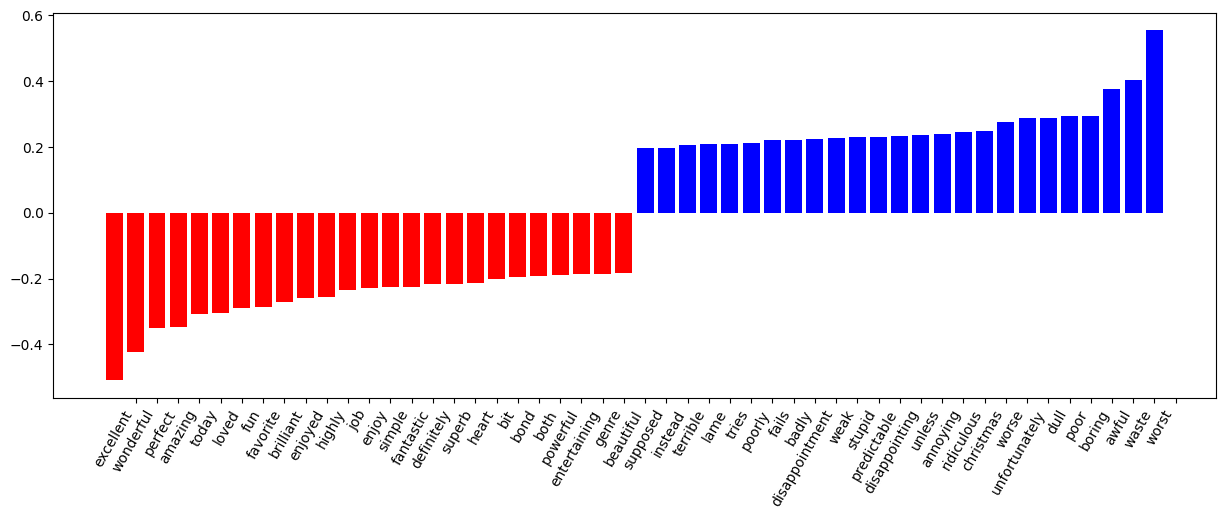

In [50]:
visualize_coefficients(logit, cv.get_feature_names_out())


Подберем коэффициент регуляризации для логистической регрессии. Используем sklearn.pipeline, поскольку CountVectorizer правильно применять только на тех данных, на которых в текущий момент обучается модель (чтоб не "подсматривать" в тестовую выборку и не считать по ней частоты вхождения слов). В данном случае pipeline задает последовательность действий: применить CountVectorizer, затем обучить логистическую регрессию. Так мы поднимаем долю правильных ответов до 88.5% на кросс-валидации и 87.9% – на отложенной выборке.


0.1324


0.11492

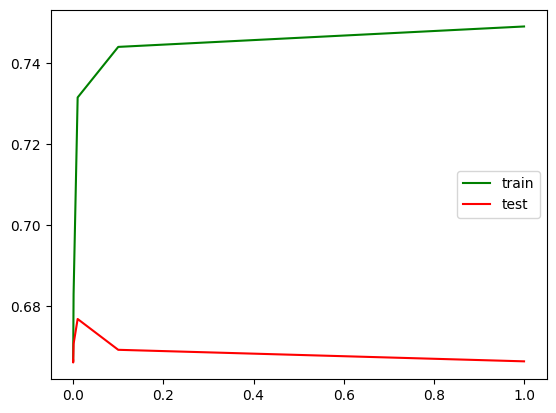

In [ ]:
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(), 
LogisticRegression(n_jobs=-1, random_state=7))

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1, return_train_score=True )

grid_logit.fit(text_train, y_train)
grid_logit.best_params_, grid_logit.best_score_
plot_grid_scores(grid_logit, 'logisticregression__C')
grid_logit.score(text_test, y_test)

In [54]:
from sklearn.pipeline import make_pipeline


text_pipe_logit = make_pipeline(
    CountVectorizer(
        lowercase=True,
        stop_words='english',     # или 'russian'
        min_df=3,                 # игнорируем слова, встречающиеся < 3 раз
        max_df=0.8,               # игнорируем слишком частые слова
        ngram_range=(1,2),        # униграммы + биграммы
    ),
    LogisticRegression(
        n_jobs=-1,
        random_state=7,
        class_weight='balanced',  # если классы несбалансированы
        max_iter=1000             # увеличим лимит итераций
    )
)

text_pipe_logit.fit(text_train, y_train)

print("Train score:", text_pipe_logit.score(text_train, y_train))
print("Test score:", text_pipe_logit.score(text_test, y_test))


Train score: 0.9950266666666666
Test score: 0.27324


In [55]:
# Подберём лучший C через GridSearchCV

from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid_logit = {
    'logisticregression__C': np.logspace(-3, 2, 10)  # от 0.001 до 100
}

grid_logit = GridSearchCV(
    text_pipe_logit,
    param_grid_logit,
    cv=3,
    n_jobs=-1,
    return_train_score=True
)

grid_logit.fit(text_train, y_train)

print("Лучшие параметры:", grid_logit.best_params_)
print("Лучшая кросс-валидационная точность:", grid_logit.best_score_)
print("Точность на тесте:", grid_logit.score(text_test, y_test))

Лучшие параметры: {'logisticregression__C': np.float64(100.0)}
Лучшая кросс-валидационная точность: 0.69076
Точность на тесте: 0.2288


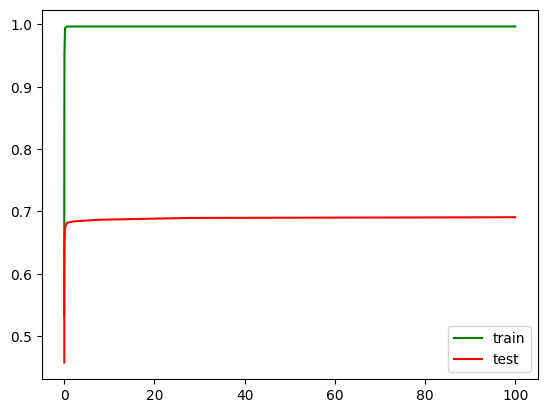

In [56]:
plot_grid_scores(grid_logit, 'logisticregression__C')

Теперь то же самое, но со случайным лесом. Видим, что с логистической регрессией мы достигаем большей доли правильных ответов меньшими усилиями. Лес работает дольше, на отложенной выборке 85.5% правильных ответов.

In [58]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)
forest.fit(X_train, y_train)

print("Train accuracy:", round(forest.score(X_train, y_train), 3))
print("Test accuracy:", round(forest.score(X_test, y_test), 3))

Train accuracy: 0.995
Test accuracy: 0.005


In [60]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,          # ограничиваем глубину
    min_samples_split=5,   # минимум объектов для разбиения
    min_samples_leaf=3,    # минимум объектов в листе
    n_jobs=-1,
    random_state=17
)
forest.fit(X_train, y_train)

print("Train accuracy:", round(forest.score(X_train, y_train), 3))
print("Test accuracy:", round(forest.score(X_test, y_test), 3))

Train accuracy: 0.667
Test accuracy: 0.0


> где то проебался но где.....

## XOR-проблема

Теперь рассмотрим пример, где линейные модели справляются хуже.

Линейные методы классификации строят все же очень простую разделяющую поверхность – гиперплоскость. Самый известный игрушечный пример, в котором классы нельзя без ошибок поделить гиперплоскостью (то есть прямой, если это 2D), получил имя "the XOR problem".

XOR – это "исключающее ИЛИ", булева функция со следующей таблицей истинности:

![image.png](../images/XOR_table.png)

XOR дал имя простой задаче бинарной классификации, в которой классы представлены вытянутыми по диагоналям и пересекающимися облаками точек.

In [61]:
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

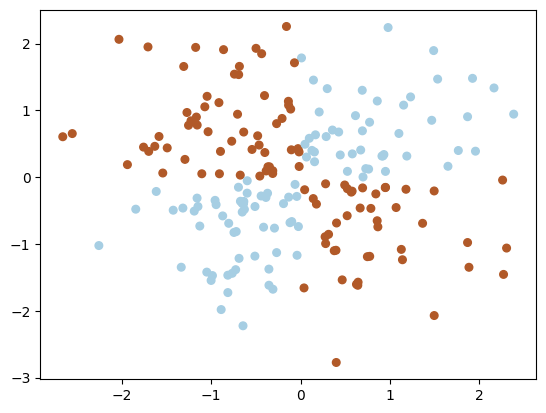

In [62]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)

In [63]:
def plot_boundary(clf, X, y, plot_title):
  xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
  np.linspace(-3, 3, 50))
  clf.fit(X, y)
  # plot the decision function for each datapoint on the grid
  Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
  Z = Z.reshape(xx.shape)

  image = plt.imshow(Z, interpolation='nearest',
  extent=(xx.min(), xx.max(), yy.min(), yy.max()),
  aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
  contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
  linetypes='--')
  plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
  plt.xticks(())
  plt.yticks(())
  plt.xlabel(r'$<!-- math>$inline$x_1$inline$</math -->$')
  plt.ylabel(r'$<!-- math>$inline$x_2$inline$</math -->$')
  plt.axis([-3, 3, -3, 3])
  plt.colorbar(image)
  plt.title(plot_title, fontsize=12)

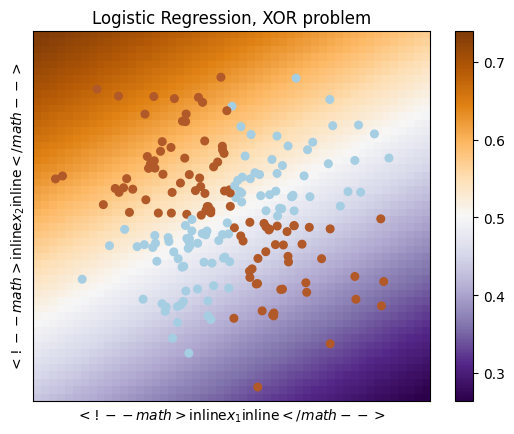

In [64]:
plot_boundary(LogisticRegression(), X, y, "Logistic Regression, XOR problem")

А если бы в качестве входных данных были даны полиномиальные признаки (здесь до 2 степени), то проблема была бы решена.

In [65]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [66]:
logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), ('logit', LogisticRegression())])

А вот если на вход подать полиномиальные признаки, в данном случае до 2 степени, то проблема решается.

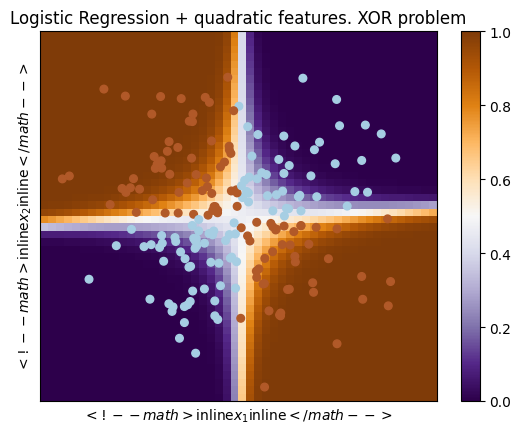

In [67]:
plot_boundary(logit_pipe, X, y, "Logistic Regression + quadratic features. XOR problem")

Здесь логистическая регрессия все равно строила гиперплоскость, но в 6-мерном пространстве признаков $1, x_1, x_2, x_1^2, x_1x_2$ и $x_2^2$. В проекции на исходное пространство признаков $x_1, x_2$ граница получилась нелинейной.

На практике полиномиальные признаки действительно помогают, но строить их явно – вычислительно неэффективно. Гораздо быстрее работает SVM с ядровым трюком. При таком подходе в пространстве высокой размерности считается только расстояние между объектами (задаваемое функцией-ядром), а явно плодить комбинаторно большое число признаков не приходится. Про это подробно можно почитать в курсе Евгения Соколова (математика уже серьезная).

### Кривые валидации и обучения

Мы уже получили представление о проверке модели, кросс-валидации и регуляризации.
Теперь рассмотрим главный вопрос:

Если качество модели нас не устраивает, что делать?

Сделать модель сложнее или упростить?
Добавить больше признаков?
Или нам просто нужно больше данных для обучения?

Ответы на данные вопросы не всегда лежат на поверхности. В частности, иногда использование более сложной модели приведет к ухудшению показателей. Либо добавление наблюдений не приведет к ощутимым изменениям. Способность принять правильное решение и выбрать правильный способ улучшения модели, собственно говоря, и отличает хорошего специалиста от плохого.

Будем работать со знакомыми данными по оттоку клиентов телеком-оператора.

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import validation_curve


In [12]:
data = pd.read_csv('resources/telecom_churn.csv').drop('State', axis=1)
data['International plan'] = data['International plan'].map({'Yes': 1, 'No': 0})
data['Voice mail plan'] = data['Voice mail plan'].map({'Yes': 1, 'No': 0})

y = data['Churn'].astype('int').values
X = data.drop('Churn', axis=1).values

Логистическую регрессию будем обучать стохастическим градиентным спуском. Пока объясним это тем, что так быстрее, но далее в программе у нас отдельная статья про это дело. Построим валидационные кривые, показывающие, как качество (ROC AUC) на обучающей и проверочной выборке меняется с изменением параметра регуляризации.

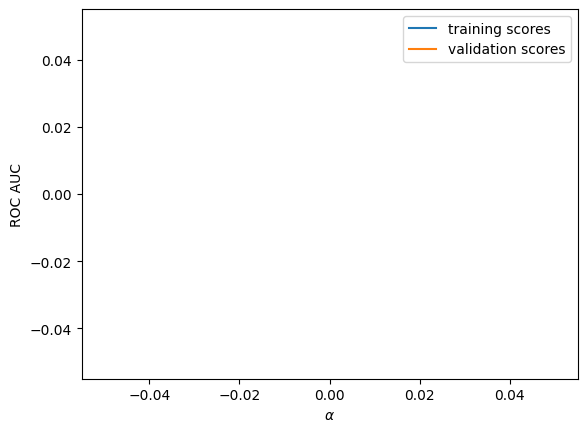

In [21]:
alphas = np.logspace(-2, 0, 20)

sgd_logit = SGDClassifier(loss='log', n_jobs=-1, random_state=17)
logit_pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=2)), ('sgd_logit', sgd_logit)]) 

val_train, val_test = validation_curve(
    logit_pipe, X, y,
    param_name='sgd_logit__alpha',
    param_range=alphas,
    cv=5,
    scoring='roc_auc'
)

def plot_with_err(x, data, **kwargs):
  mu, std = data.mean(1), data.std(1)
  lines = plt.plot(x, mu, '-', **kwargs)
  plt.fill_between(x, mu - std, mu + std, edgecolor='none',
  facecolor=lines[0].get_color(), alpha=0.2)
  

plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel(r'$\alpha$'); plt.ylabel('ROC AUC')
plt.legend()

> Тоже бред какой то

Тенденция видна сразу, и она очень часто встречается.

Для простых моделей тренировочная и валидационная ошибка находятся где-то рядом, и они велики. Это говорит о том, что модель недообучилась: то есть она не имеет достаточное кол-во параметров.

Для сильно усложненных моделей тренировочная и валидационная ошибки значительно отличаются. Это можно объяснить переобучением: когда параметров слишком много либо не хватает регуляризации, алгоритм может "отвлекаться" на шум в данных и упускать основной тренд.



... что то делаю не то нужно позже вернуться к этому уроку ... 